## GraphSAGE: Inductive Representation Learning on Large Graphs

<div align="center">
    <img style="border-radius: 0.3125em; box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);"
    height="150"
    src="https://github.com/ximingxing/Images/raw/master/dlic/gnn/GraphSage.png">
    <br>
    <div style="border-bottom: 1px solid #d9d9d9;display:inline-block;color: #999;padding: 2px;
    font-style: oblique; font-family: 'Times New Roman'">
    Figure: W.L. Hamilton, Inductive Representation Learning on Large Graphs (2017)</div>
</div>

**GraphSAGE**是一个用于大型图上归纳表示学习的框架;
**GraphSAGE**用于为节点生成低维向量表示, 对于具有丰富节点属性信息的图尤其有用。

### Import packages

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print('pytorch version:',torch.__version__,
      '\nnumpy version:' ,np.__version__,
      '\nmatplotlib version:' ,matplotlib.__version__)

# (可选) 适配项目路径
import sys
sys.path.insert(0, "/root/workshop/Deep-Learning-in-Action")

%matplotlib inline

pytorch version: 1.7.1+cu101 
numpy version: 1.18.2 
matplotlib version: 3.2.1


### Defining hyperparameters

In [13]:
INPUT_DIM = 1433 # 输入维度
# Note: 采样的邻居阶数需要与GCN的层数保持一致
HIDDEN_DIM = [128, 7]   # 隐藏单元节点数
NUM_NEIGHBORS_LIST = [10, 10]   # 每阶采样邻居的节点数
assert len(HIDDEN_DIM) == len(NUM_NEIGHBORS_LIST)

BATCH_SIZE = 16 # 批处理大小
EPOCHS = 20
NUM_BATCH_PER_EPOCH = 20 # 每个epoch循环的批次数
LEARNING_RATE = 0.01 # 学习率
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

### Load Dataset: Cora

In [14]:
from graph_neural_networks.GraphSage.cora import CoraData
from collections import namedtuple

Data = namedtuple('Data', ['x', 'y', 'adjacency_dict',
                           'train_mask', 'val_mask', 'test_mask'])

# 加载数据，并转换为torch.Tensor
dataset = CoraData(data_root='/root/data/cora', rebuild=True).data
x = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
train_idx = np.where(dataset.train_mask)[0]
train_label = dataset.y
test_idx = np.where(dataset.test_mask)[0]

Process data ...
/root/data/cora/raw/ind.cora.x
/root/data/cora/raw/ind.cora.tx
/root/data/cora/raw/ind.cora.allx
/root/data/cora/raw/ind.cora.y
/root/data/cora/raw/ind.cora.ty
/root/data/cora/raw/ind.cora.ally
/root/data/cora/raw/ind.cora.graph
Node's feature shape:  (2708, 1433)
Node's label shape:  (2708,)
Adjacency's shape:  2708
Number of training nodes:  140
Number of validation nodes:  500
Number of test nodes:  1000
Cached file: /root/data/cora/cora_cached.pkl


### Build GraphSage, define optimizer and loss function

In [15]:
from graph_neural_networks.GraphSage.model import GraphSage

model = GraphSage(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
                  num_neighbors_list=NUM_NEIGHBORS_LIST).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

### Define training function

In [16]:
from graph_neural_networks.GraphSage.sampling import multihop_sampling

def train():
    model.train()
    for e in range(EPOCHS):
        for batch in range(NUM_BATCH_PER_EPOCH):
            bth_src_idx = np.random.choice(train_idx, size=(BATCH_SIZE,))
            bth_src_label = torch.from_numpy(train_label[bth_src_idx]).long().to(DEVICE)
            bth_sampling_res = multihop_sampling(bth_src_idx, NUM_NEIGHBORS_LIST, dataset.adjacency_dict)
            bth_sampling_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in bth_sampling_res]

            bth_train_logits = model(bth_sampling_x)
            loss = criterion(bth_train_logits, bth_src_label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("Epoch {:03d} Batch {:03d} Loss: {:.4f}".format(e, batch, loss.item()))
        test()


@torch.no_grad()
def test():
    model.eval()
    test_sampling_result = multihop_sampling(test_idx, NUM_NEIGHBORS_LIST, dataset.adjacency_dict)
    test_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in test_sampling_result]
    test_label = torch.from_numpy(dataset.y[test_idx]).long().to(DEVICE)

    test_logits = model(test_x)
    predict_y = test_logits.max(1)[1]
    accuarcy = torch.eq(predict_y, test_label).float().mean().item()
    print("--------------------------------")
    print("Test Accuracy: ", accuarcy)
    print("--------------------------------")
    return test_logits.cpu().numpy(), test_label.cpu().numpy()

### Training model

In [17]:
train()
test_logits, test_label = test()

Epoch 000 Batch 000 Loss: 1.9081
Epoch 000 Batch 001 Loss: 1.8463
Epoch 000 Batch 002 Loss: 1.6477
Epoch 000 Batch 003 Loss: 1.6980
Epoch 000 Batch 004 Loss: 1.6418
Epoch 000 Batch 005 Loss: 1.6857
Epoch 000 Batch 006 Loss: 1.5881
Epoch 000 Batch 007 Loss: 1.3661
Epoch 000 Batch 008 Loss: 0.9846
Epoch 000 Batch 009 Loss: 1.0829
Epoch 000 Batch 010 Loss: 0.8724
Epoch 000 Batch 011 Loss: 0.8792
Epoch 000 Batch 012 Loss: 0.6740
Epoch 000 Batch 013 Loss: 0.6939
Epoch 000 Batch 014 Loss: 0.4811
Epoch 000 Batch 015 Loss: 0.7280
Epoch 000 Batch 016 Loss: 0.4199
Epoch 000 Batch 017 Loss: 0.2642
Epoch 000 Batch 018 Loss: 0.5687
Epoch 000 Batch 019 Loss: 0.4544
--------------------------------
Test Accuracy:  0.7270000576972961
--------------------------------
Epoch 001 Batch 000 Loss: 0.2489
Epoch 001 Batch 001 Loss: 0.3816
Epoch 001 Batch 002 Loss: 0.2522
Epoch 001 Batch 003 Loss: 0.2084
Epoch 001 Batch 004 Loss: 0.2926
Epoch 001 Batch 005 Loss: 0.1749
Epoch 001 Batch 006 Loss: 0.1160
Epoch 00

### Visual model training results

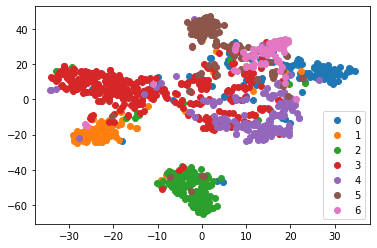

In [18]:
# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()